# Intro to Object Detection Colab

Welcome to the object detection colab! This demo will take you through the steps of running an "out-of-the-box" detection model in SavedModel format on a collection of images.



Imports

In [1]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import pathlib
import pickle

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
import visualization_utils as viz_utils

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [3]:
def result_over_score_thersh(detections,score_thersh=0.5):
    (boxes,classes,scores) = (detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy())
    truth_num=sum(scores>score_thersh)
    (truth_boxes,truth_classes,truth_scores) = (boxes[0:truth_num],classes[0:truth_num],scores[0:truth_num])
    truth_detections = {'boxes':truth_boxes, 'classes':truth_classes, 'scores':truth_scores}
    return truth_detections

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
MODELS = {'rcnn_in_1024': 'faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8',
          'rcnn_in_640': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8',
          'rcnn_res_1024': 'faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8',
          'rcnn_res_640': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
          'ssd_res_1024': 'ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8',
          'ssd_res_640': 'ssd_resnet152_v1_fpn_640x640_coco17_tpu-8',
          'ssd_mo_640': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
          'ssd_mo_320': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8' }

model_display_name = 'ssd_res_1024'
model_display_name = 'ssd_res_640'
model_name = MODELS[model_display_name]

In [6]:
model_name

'ssd_resnet152_v1_fpn_640x640_coco17_tpu-8'

In [7]:
model_path = "/home/hezhaoliang/.keras/models/"+model_name+"/saved_model/"

In [8]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load(model_path)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 34.16347885131836s


Elapsed time: 0.09236502647399902 second per image


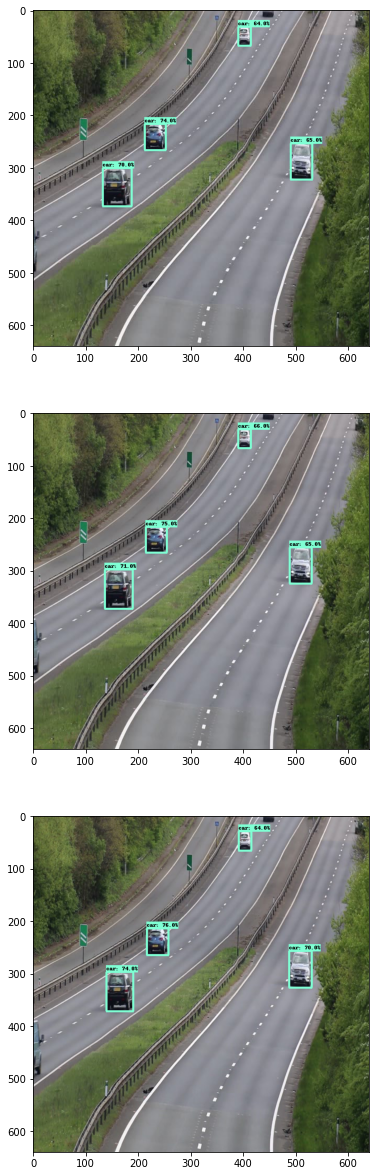

In [9]:
resolution = "640x640" #"1024x1024" # "640x640" "320x320" 
image_dir = "/home/hezhaoliang/PerConfigure/dataset/youtube/demo1_10s_15_"+resolution
result_path = "/home/hezhaoliang/PerConfigure/results/"+model_display_name 
elapsed = []
detections_results = []
image_number = 3
score_thresh = 0.5
# image_number = len(os.listdir(image_dir))
for i in range(image_number):   
  image_path = os.path.join(image_dir, 'image-' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)
  detections_result =  result_over_score_thersh(detections)
  detections_results.append(detections_result)
  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
#         min_score_thresh=.50,
        min_score_thresh=score_thresh,
        agnostic_mode=False)
  plt.subplot(image_number, 1, i+1)
  plt.imshow(image_np_with_detections)
# with open(result_path+'.defaultdict', 'wb') as f:
#     pickle.dump(detections_results, f)
# with open(result_path+'.defaultdict', 'rb') as f:
#     ground_truths = pickle.load(f)
mean_elapsed = sum(elapsed[1:]) / float(len(elapsed)-1)
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

In [11]:
# len(ground_truths)
len(detections_results)

3

In [13]:
# ground_truths
detections_results

[{'boxes': array([[0.339902  , 0.3321986 , 0.41677102, 0.39617273],
         [0.47130942, 0.20774324, 0.5843464 , 0.29388773],
         [0.39692554, 0.7663598 , 0.5034468 , 0.83223546],
         [0.0505436 , 0.60984755, 0.10602397, 0.6488408 ]], dtype=float32),
  'classes': array([3, 3, 3, 3], dtype=int32),
  'scores': array([0.7359159 , 0.6962323 , 0.64883006, 0.64374846], dtype=float32)},
 {'boxes': array([[0.33906698, 0.3352933 , 0.41509724, 0.39911938],
         [0.4656265 , 0.21340732, 0.58211076, 0.29726478],
         [0.04861436, 0.6105018 , 0.10410913, 0.649718  ],
         [0.4007119 , 0.763917  , 0.50694835, 0.8304567 ]], dtype=float32),
  'classes': array([3, 3, 3, 3], dtype=int32),
  'scores': array([0.7517011 , 0.70703715, 0.6562712 , 0.65123117], dtype=float32)},
 {'boxes': array([[0.33537832, 0.33841017, 0.41257623, 0.40322688],
         [0.4649899 , 0.21760285, 0.58011293, 0.29964972],
         [0.40252396, 0.76187617, 0.5102598 , 0.83022934],
         [0.04681024, 0.61

In [14]:
elapsed

[7.7233991622924805, 0.0951082706451416, 0.08962178230285645]